In [1]:
#import necessary library 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split ,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score,recall_score  
from sklearn.metrics import classification_report ,confusion_matrix
import xgboost as xgb


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.optimizers import Adam


from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import time 



In [2]:
df=pd.read_csv("../data/processed/data_v1.csv")


colums to drop are "Caudal_impulses" "Oil_level" ,"Pressure_switch" ,"LPS" "Reservoirs"

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221948 entries, 0 to 1221947
Data columns (total 16 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   TP2              1221948 non-null  float64
 1   TP3              1221948 non-null  float64
 2   H1               1221948 non-null  float64
 3   DV_pressure      1221948 non-null  float64
 4   Reservoirs       1221948 non-null  float64
 5   Oil_temperature  1221948 non-null  float64
 6   Motor_current    1221948 non-null  float64
 7   COMP             1221948 non-null  float64
 8   DV_eletric       1221948 non-null  float64
 9   Towers           1221948 non-null  float64
 10  MPG              1221948 non-null  float64
 11  LPS              1221948 non-null  float64
 12  Pressure_switch  1221948 non-null  float64
 13  Oil_level        1221948 non-null  float64
 14  Caudal_impulses  1221948 non-null  float64
 15  Air_Leak         1221948 non-null  int64  
dtypes: float64(15), in

In [4]:
df["Air_Leak"].value_counts()

Air_Leak
0    1196741
1      25207
Name: count, dtype: int64

In [5]:
df.drop(columns=["Reservoirs","COMP","Caudal_impulses","Pressure_switch","H1"],inplace=True)

In [6]:
X=df.drop(columns=["Air_Leak"])
y=df["Air_Leak"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (977558, 10)
Shape of X_test: (244390, 10)
Shape of y_train: (977558,)
Shape of y_test: (244390,)


In [8]:
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(f"\n Time Taken {thour} hours {tmin} minutes and {round(tsec,2)} seconds ")

In [9]:
start_time=time.time()

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
pipeline_resam = Pipeline([
    ('scaler', MinMaxScaler()),                                
    ('xgb', xgb.XGBClassifier())                  
])

pipeline_resam.fit(X_train_resampled, y_train_resampled)
y_pred_resam = pipeline_resam.predict(X_test)

end_time=time.time()
elapsed_time=end_time-start_time
test_acc=accuracy_score(y_test,y_pred_resam)
test_precision=precision_score(y_test,y_pred_resam)
test_f1_score=f1_score(y_test,y_pred_resam)
recall_score=recall_score(y_test,y_pred_resam)

print(f"Testing Accuracy: {test_acc * 100:.2f}%")
print(f"Testing test_precision: {test_precision * 100:.2f}%")
print(f"Testing test_f1_score: {test_f1_score * 100:.2f}%")
print(f"Testing recall_score: {recall_score * 100:.2f}%")
print("Time taken for model (seconds):", elapsed_time)



Testing Accuracy: 99.52%
Testing test_precision: 81.38%
Testing test_f1_score: 89.66%
Testing recall_score: 99.80%
Time taken for model (seconds): 11.179603576660156


In [10]:
print("Classification Report:")
print(classification_report(y_test, y_pred_resam))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    239327
           1       0.81      1.00      0.90      5063

    accuracy                           1.00    244390
   macro avg       0.91      1.00      0.95    244390
weighted avg       1.00      1.00      1.00    244390



In [11]:
param_distributions = {
    'xgb__n_estimators': randint(50, 500),  
    'xgb__max_depth': randint(3, 15),      
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2,0.3], 
    'xgb__subsample': [0.5, 0.7, 1.0],      
    'xgb__colsample_bytree': [0.5, 0.7, 1.0]  
}

# Set up Randomized Search
random_search_xg = RandomizedSearchCV(
    pipeline_resam,
    param_distributions,
    n_iter=5,  
    scoring='roc_auc',  
    cv=5,  
    verbose=3,  
    n_jobs=-1 
)
start_time=timer(None)
random_search_xg.fit(X_train, y_train)
timer(start_time)



Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time Taken 0.0 hours 4.0 minutes and 2.37 seconds 


In [12]:
# Get the best parameters and score
best_params = random_search_xg.best_params_
best_estima = random_search_xg.best_estimator_
best_score = random_search_xg.best_score_

print("Best Parameters:", best_params)
print("Best estimator:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 13, 'xgb__n_estimators': 181, 'xgb__subsample': 0.7}
Best estimator: {'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 13, 'xgb__n_estimators': 181, 'xgb__subsample': 0.7}
Best Cross-Validation Score: 0.9999502742551389


In [13]:
best_pipeline_xg = random_search_xg.best_estimator_
y_pred_xg = best_pipeline_xg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xg))
print("Precision:", precision_score(y_test, y_pred_xg))
print("f1_socre:", f1_score(y_test, y_pred_xg))
print("Recall:", recall_score(y_test, y_pred_xg))

print("Classification Report:\n", classification_report(y_test, y_pred_xg))
print("confusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))

Accuracy: 0.9949629690249192
Precision: 0.8050955414012739
f1_socre: 0.8914749184519086
Recall: 0.9986174205016789
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    239327
           1       0.81      1.00      0.89      5063

    accuracy                           0.99    244390
   macro avg       0.90      1.00      0.94    244390
weighted avg       1.00      0.99      1.00    244390

confusion Matrix:
 [[238103   1224]
 [     7   5056]]


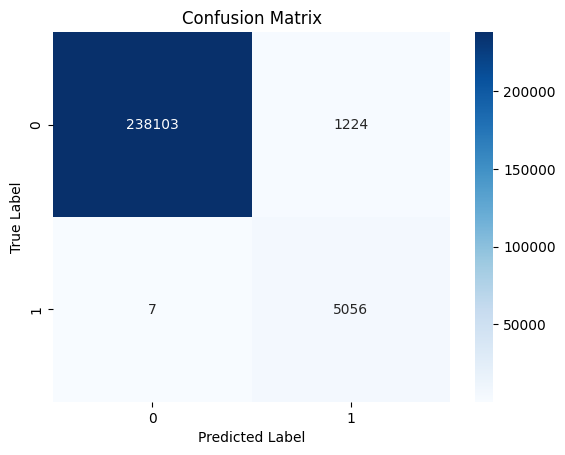

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [95]:
pipeline_rf = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  
    ('scaler', MinMaxScaler()),                                
    ('rf', RandomForestClassifier())                  
])
param_rf = {
    'rf__n_estimators':[100,200,300],
    'rf__max_depth': [5,6,9,11,13,15],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}
rf_clasifier=RandomizedSearchCV(pipeline_rf,param_distributions=param_rf,n_iter=5,  
    scoring='accuracy',  
    cv=5,  
    verbose=3,  
    n_jobs=-1)

start_time=timer(None)
rf_clasifier.fit(X_train, y_train)
timer(start_time)

# Get the best parameters and score
best_params = rf_clasifier.best_params_
best_estima = rf_clasifier.best_estimator_
best_score = rf_clasifier.best_score_

print("Best Parameters:", best_params)
print("Best estimator:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [ ]:
best_pipeline_rf = rf_clasifier.best_estimator_
y_pred_rf = best_pipeline_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("f1_socre:", f1_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))

print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.9971
Precision: 0.900390625
f1_socre: 0.9451190663933133
Recall: 0.9945237305011616
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233974
           1       0.90      0.99      0.95      6026

    accuracy                           1.00    240000
   macro avg       0.95      1.00      0.97    240000
weighted avg       1.00      1.00      1.00    240000

confusion Matrix:
 [[233311    663]
 [    33   5993]]


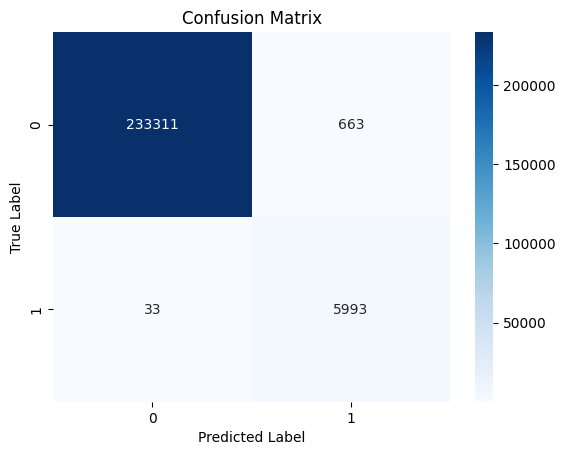

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [17]:
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),                                
    ('dt', DecisionTreeClassifier())                  
])
param_dt = {
    'dt__criterion':['gini','entropy'],
    'dt__max_depth': [5,6,9,11,13,15],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}
dt_clasifier=RandomizedSearchCV(pipeline_dt,param_distributions=param_dt,n_iter=5,  
    scoring='accuracy',  
    cv=5,  
    verbose=3,  
    n_jobs=-1)

start_time=timer(None)
dt_clasifier.fit(X_train_resampled, y_train_resampled)
timer(start_time)

# Get the best parameters and score
best_params_dt = dt_clasifier.best_params_
best_estima_dt = dt_clasifier.best_estimator_
best_score_dt = dt_clasifier.best_score_

print("Best Parameters:", best_params_dt)
print("Best estimator:", best_estima_dt)
print("Best Cross-Validation Score:", best_score_dt)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time Taken 0.0 hours 1.0 minutes and 17.03 seconds 
Best Parameters: {'dt__min_samples_split': 2, 'dt__min_samples_leaf': 2, 'dt__max_depth': 15, 'dt__criterion': 'gini'}
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('dt',
                 DecisionTreeClassifier(max_depth=15, min_samples_leaf=2))])
Best Cross-Validation Score: 0.9973094190226828


In [18]:
best_pipeline_dt = dt_clasifier.best_estimator_
y_pred_dt = best_pipeline_dt.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("f1_socre:", f1_score(y_test, y_pred_dt))

print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Accuracy: 0.9946847252342568
Precision: 0.7994907702100573
f1_socre: 0.8855204018683352
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    239327
           1       0.80      0.99      0.89      5063

    accuracy                           0.99    244390
   macro avg       0.90      0.99      0.94    244390
weighted avg       1.00      0.99      0.99    244390

confusion Matrix:
 [[238067   1260]
 [    39   5024]]


In [24]:
data_v2=pd.read_csv(f"../data/processed/data_v2.csv")
data_v2.drop(columns=["Air_Leak","Reservoirs","COMP","Caudal_impulses","Pressure_switch","H1"],inplace=True)
prediction=best_pipeline_dt.predict(data_v2)
# Get unique values and their counts
unique, counts = np.unique(prediction, return_counts=True)

# Create a dictionary of counts
prediction_counts = dict(zip(unique, counts))

# Print the counts
print(prediction_counts)



{0: 291974, 1: 3026}


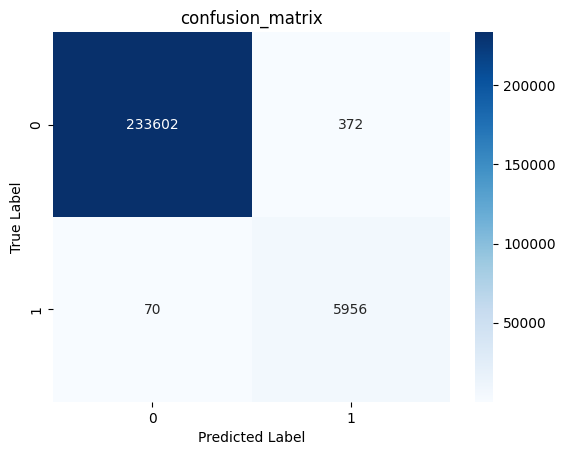

In [ ]:
conf_matrix=confusion_matrix(y_test,y_pred_dt)
sns.heatmap(conf_matrix,cmap="Blues",annot=True,fmt="g")
plt.title("confusion_matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
#pour testing pytest or deepchecks test 9bal docker
#docker frontend 
#docker backend
#arize ai ml monitoring tools

In [58]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_train_resampled.shape





(1914828, 10)

In [54]:
def create_seq(X,y,time_steps=10):
    X_seq = []
    y_seq = []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y.iloc[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_seq(X_train_resampled, y_train_resampled)
X_val_seq, y_val_seq = create_seq(X_val_scaled,y_val)
 

In [56]:
print(X_train_seq.shape)  
print(X_val_seq.shape) 

(1914818, 10, 10)
(244380, 10, 10)


In [91]:
model=Sequential()
model.add(LSTM(32, activation="tanh", input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(16, activation="tanh", return_sequences=False))
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.2))

# Output layer for binary classification
model.add(Dense(1, activation="sigmoid"))


In [92]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=0.0001),loss="binary_crossentropy",metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [93]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 10, 32)         │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,785 (34.32 KB)

 Trainable params: 8,785 (34.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(X_train_seq,y_train_seq,epochs=5,batch_size=32,
                  validation_data=(X_val_seq,y_val_seq),callbacks=[early_stopping],
                  verbose=1
                  )

Epoch 1/5
29920/29920 ━━━━━━━━━━━━━━━━━━━━ 183s 6ms/step - accuracy: 0.9706 - loss: 0.1141 - val_accuracy: 0.9793 - val_loss: 0.1010
Epoch 2/5
29920/29920 ━━━━━━━━━━━━━━━━━━━━ 179s 6ms/step - accuracy: 0.9889 - loss: 0.0563 - val_accuracy: 0.9793 - val_loss: 0.1009
Epoch 3/5
29920/29920 ━━━━━━━━━━━━━━━━━━━━ 180s 6ms/step - accuracy: 0.9887 - loss: 0.0554 - val_accuracy: 0.9793 - val_loss: 0.1009
Epoch 4/5
29920/29920 ━━━━━━━━━━━━━━━━━━━━ 178s 6ms/step - accuracy: 0.9887 - loss: 0.0547 - val_accuracy: 0.9793 - val_loss: 0.1009
Epoch 5/5
 1560/29920 ━━━━━━━━━━━━━━━━━━━━ 2:50 6ms/step - accuracy: 0.9887 - loss: 0.0538

KeyboardInterrupt: 

In [78]:
loss, accuracy = model.evaluate(X_val_seq, y_val_seq)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


7637/7637 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9796 - loss: 0.1015
Validation Loss: 0.1024312973022461
Validation Accuracy: 0.9792822599411011


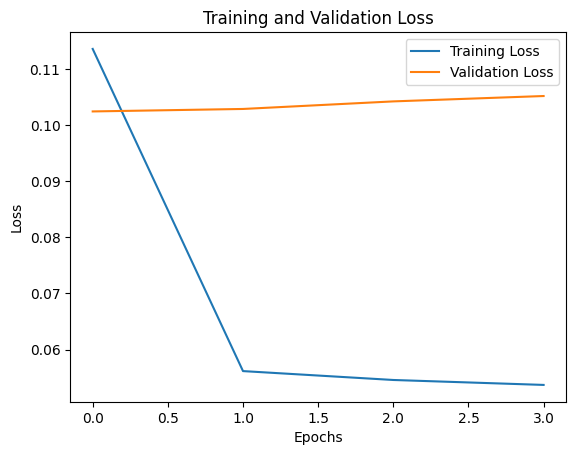

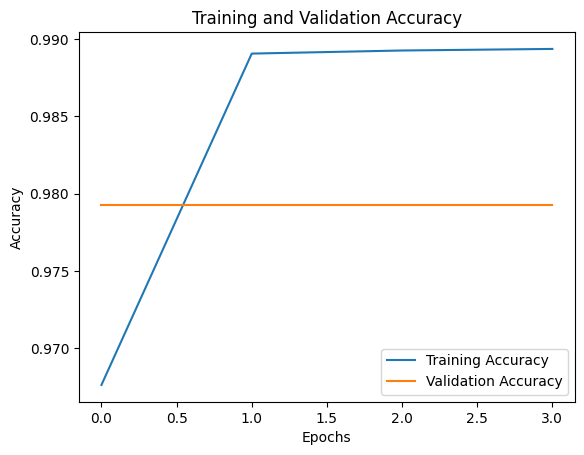

In [81]:
# Visualize training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
